In [735]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [736]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/


In [737]:
data_flag = 'pneumoniamnist'
#data_flag = 'pathmnist'
#data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 50
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [738]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

Using downloaded and verified file: /home/caesar/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/caesar/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/caesar/.medmnist/pneumoniamnist.npz


In [739]:
print(train_dataset)

Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 4708
    Root location: /home/caesar/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0


In [740]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

EMBEDDING_LEN = 16

# Load MNIST dataset
(x_train, y_train) = (train_dataset.imgs, train_dataset.labels)
(x_test, y_test) = (test_dataset.imgs, test_dataset.labels)

In [741]:
print(x_train.shape)
print(y_train.shape)

(4708, 28, 28)
(4708, 1)


In [742]:
# Preprocess images
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Get the user-specified embedding length
embedding_length = EMBEDDING_LEN

# Define a CNN model with variable embedding length
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(embedding_length, activation='relu'),  # Embedding layer with variable length
# ])  # Remove the final classification layer

model = Sequential([
    # Initial convolutional block
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Second convolutional block for deeper feature extraction
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten and dense layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularization to prevent overfitting
    Dense(embedding_length, activation='relu')  # Variable-length embedding layer
])

In [743]:
# Compile the model (important for generating meaningful embeddings)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [744]:
# Extract embeddings for all images in the training set
embeddings_train = model.predict(x_train)
print(embeddings_train.shape)  # Output: (60000, embedding_length)

148/148 [==============================] - 0s 2ms/step
(4708, 16)


In [745]:
# Optionally, extract embeddings for test images
embeddings_test = model.predict(x_test)
print(embeddings_test.shape)  # Output: (10000, embedding_length)

20/20 [==============================] - 0s 2ms/step
(624, 16)


In [746]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
#(, y_train), (x_test, y_test)

(4708, 28, 28, 1)
(4708, 1)
(624, 28, 28, 1)
(624, 1)


In [747]:
import numpy as np
from sklearn.svm import SVC

In [748]:
# Load your dataset (assuming it's in NumPy arrays)
x_train = embeddings_train
y_train = y_train
x_test = embeddings_test
y_test = y_test

In [749]:
# Create an SVM classifier with a suitable kernel
clf = SVC(kernel='rbf', C=1.0, gamma='scale')  # RBF kernel often works well

In [750]:
# Fit the classifier on the training data
y_train = y_train.ravel()
clf.fit(x_train, y_train)

SVC()

In [751]:
# Make predictions on the test data
y_pred = clf.predict(x_test)

In [752]:
# Evaluate model performance
y_test = y_test.ravel()
accuracy = clf.score(x_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8509615384615384


              precision    recall  f1-score   support

           0       0.87      0.71      0.78       234
           1       0.84      0.93      0.89       390

    accuracy                           0.85       624
   macro avg       0.85      0.82      0.83       624
weighted avg       0.85      0.85      0.85       624



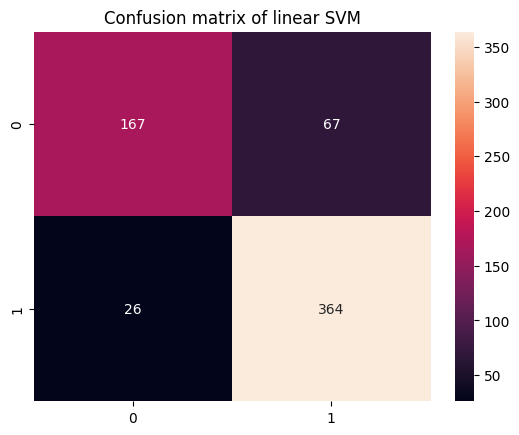

In [753]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion matrix of linear SVM') # fmt='d' formats the numbers as digits, which means integers

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1214
           1       0.92      0.94      0.93      3494

    accuracy                           0.89      4708
   macro avg       0.87      0.85      0.86      4708
weighted avg       0.89      0.89      0.89      4708



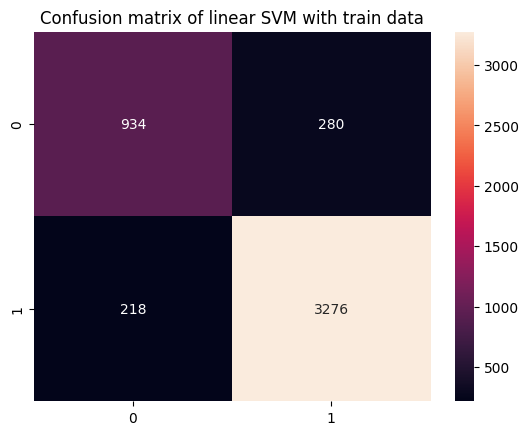

In [754]:
y_pred_train = clf.predict(x_train)

cm_train = confusion_matrix(y_train,y_pred_train)
sns.heatmap(cm_train, annot=True, fmt='d').set_title('Confusion matrix of linear SVM with train data')

print(classification_report(y_train,y_pred_train))

In [755]:
clf.get_params()
print(clf.n_support_)

[704 705]


In [756]:
# get the actual output of SVM
decision_function = clf.decision_function(x_test)
print(decision_function)

[ 1.93600543e+00  1.79680535e+00 -8.10756587e-01 -1.58560284e+00
  2.73250099e+00  2.76971805e+00  1.46715137e+00  2.55914243e+00
  2.29735501e+00  6.29887604e-01  3.20853180e+00  1.81880435e+00
  1.44131661e+00  2.52478577e+00 -3.93593204e-01  1.08152927e+00
  3.55756101e+00 -7.24774744e-01  2.44357484e+00  3.35167127e-01
  1.08590013e-01  2.51525667e+00  1.42704048e+00  3.58529913e-01
  1.49420063e+00 -2.03206833e+00  2.38191375e+00 -1.30165884e+00
 -4.50141899e-01  2.81045502e+00 -1.33121336e+00  1.31382901e+00
  2.56417630e+00  2.70552254e+00  2.57583989e+00  6.78827734e-01
 -1.25689523e+00  1.42905517e+00  6.47002427e-01  1.68316541e-01
  2.67223222e+00 -5.39688786e-01 -2.07933069e+00 -1.71943863e+00
  2.20761080e-01  2.53330016e+00 -9.47659874e-01  2.52071943e+00
  1.66889133e+00  1.41949785e+00  5.31901898e-01  1.64852180e+00
 -1.01247975e+00  2.88348737e+00 -1.41967532e+00 -1.47322329e+00
  1.18167367e+00 -1.85844331e+00 -1.84050776e+00  1.63598790e+00
 -1.95818574e+00 -1.20992

In [757]:
import numpy as np
print("svc.gamma: ", clf.gamma)
print("svc.degree: ", clf.degree)

sv=open("../data-kernel-model-rbf/support_vectors_rbf.txt","w")
dual_coeff=open("../data-kernel-model-rbf/dual_coeff_rbf.txt","w")
intercept=open("../data-kernel-model-rbf/intercept_rbf.txt","w")
xtestSample="../data-kernel-model-rbf/xtest_rbf.txt"
ytestSample="../data-kernel-model-rbf/ytest_rbf.txt"
ytestClassificationScore="../data-kernel-model-rbf/yclassificationscore.txt"

np.savetxt(sv,clf.support_vectors_)
    
np.savetxt(dual_coeff,clf.dual_coef_,delimiter=' ')
np.savetxt(intercept,clf.intercept_,delimiter=' ')

with open(xtestSample, "w") as f1:
    for item in x_test[0]:  # Access the first row directly
        f1.write(str(item) + " ")
        
with open(ytestClassificationScore, "w") as f2:
    f2.write(str(decision_function[0]))
    
with open(ytestSample, "w") as f3:
    f3.write(str(y_test[0]))
    
sv.close()
dual_coeff.close()
intercept.close()
f1.close()
f2.close()
f3.close()

svc.gamma:  scale
svc.degree:  3
